In [1]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('C:/Users/rodia/PycharmProjects/NavAut_Final_Eq3/image_data.csv')
print(data.head())

                                      Filename  Steering Angle
0  captured_images/2024-06-21 22-47-52-591.png   -1.175409e-15
1  captured_images/2024-06-21 22-47-53-141.png    5.947467e-11
2  captured_images/2024-06-21 22-47-53-677.png   -1.083598e-11
3  captured_images/2024-06-21 22-47-54-189.png   -2.537948e-11
4  captured_images/2024-06-21 22-47-54-228.png   -7.374533e-11


In [3]:
def load_image(filepath):
    return cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
data['image'] = data['Filename'].apply(load_image)

In [4]:
print(f"Total images loaded: {len(data)}")

Total images loaded: 18210


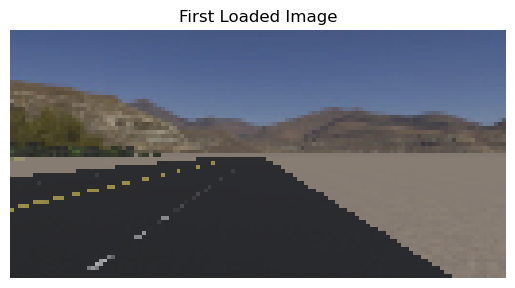

In [5]:
plt.imshow(data.iloc[0]['image'])
plt.title('First Loaded Image')
plt.axis('off')  # Oculta los ejes
plt.show()

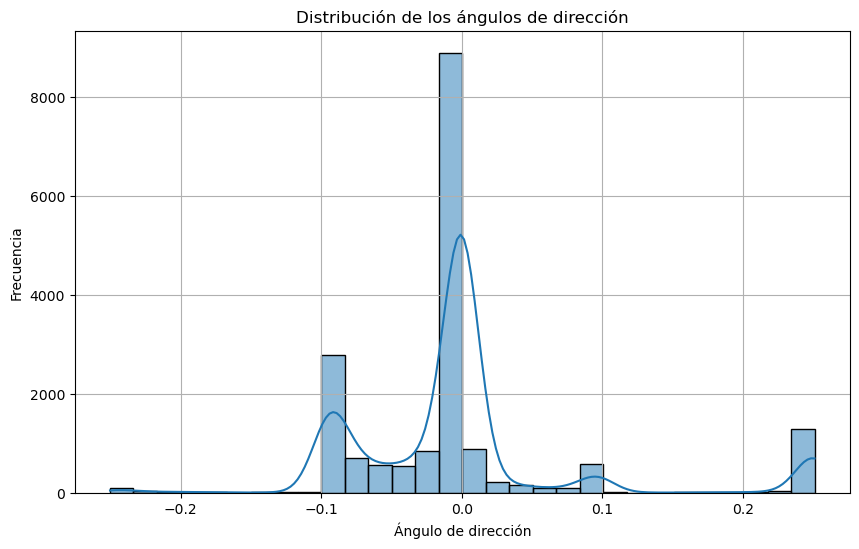

In [6]:
import seaborn as sns

# Crear un histograma de los ángulos de dirección
plt.figure(figsize=(10, 6))
sns.histplot(data['Steering Angle'], bins=30, kde=True)
plt.title('Distribución de los ángulos de dirección')
plt.xlabel('Ángulo de dirección')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [7]:
train_samples, validation_samples = train_test_split(data, test_size=0.2)

In [8]:
#print("Max Angle:", data['Steering Angle'].max())
#print("Min Angle:", data['Steering Angle'].min())

In [9]:
import cv2
import numpy as np

def augment_image(image):

    # Cambio de brillo
    if np.random.rand() > 0.2:
        factor = np.random.uniform(0.4, 1.5)
        image = np.clip(image * factor, 0, 255)
    
    return image

def data_generator(data, batch_size=32):
    #max_angle = data['Steering Angle'].max()
    #min_angle = data['Steering Angle'].min()
    while True:
        data = data.sample(frac=1)  # Reordenar los datos en cada época
        for offset in range(0, len(data), batch_size):
            batch_samples = data.iloc[offset:offset+batch_size]
            images = []
            angles = []
            for _, row in batch_samples.iterrows():
                image = row['image']
                angle = row['Steering Angle']
                
                # Normalizar el ángulo en el rango de -1 a 1
                normalized_angle = angle # 2 * (angle - min_angle) / (max_angle - min_angle) - 1
                
                # Aplicar data augmentation si necesario
                image = augment_image(image)
                image = cv2.resize(image, (200, 66))
                image = image / 255.0 - 0.5

                # Añadir imagen y ángulo normalizado al lote
                images.append(image)
                angles.append(normalized_angle)
            
            # Convertir listas a numpy arrays
            images = np.array(images)
            angles = np.array(angles)
            yield images, angles



In [10]:
model = Sequential([
    # Lambda(custom_lambda_function, input_shape=(66, 200, 3)),  # Si deseas usar una función lambda para preprocesamiento
    Conv2D(24, (5, 5), strides=(2, 2), activation='relu', input_shape=(66, 200, 3)),  # Añade el input_shape aquí
    Conv2D(36, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(48, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),  # Aplanamiento de los datos para pasar de convolucional a densa
    Dense(1164, activation='relu'),  # Ajustar el número de neuronas si es necesario
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)  # Salida
])

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))

C:\Users\rodia\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1164)           │     1,342,092 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       116,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,595,511 (6.09 MB)

 Trainable params: 1,595,511 (6.09 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
train_generator = data_generator(train_samples, batch_size=32)
val_generator = data_generator(validation_samples, batch_size=32)

In [13]:
for images, angles in train_generator:
    print(images.shape)  # Debería imprimir algo como (batch_size, 66, 200, 3)
    break

(32, 66, 200, 3)


In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_samples) // 32,
    validation_data=val_generator,
    validation_steps=len(validation_samples) // 32,
    epochs=10,
    verbose=1
)

Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0011 - val_loss: 9.2642e-04
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 8.8064e-04 - val_loss: 8.5436e-04
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 7.2230e-04 - val_loss: 7.0256e-04
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 6.2110e-04 - val_loss: 7.4190e-04
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 5.6909e-04 - val_loss: 5.6652e-04
Epoch 9/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 4.8353e-04 - val_loss: 5.5356e-04
Epoch 10/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 4.7873e-04 - val_loss: 5.1031e-04


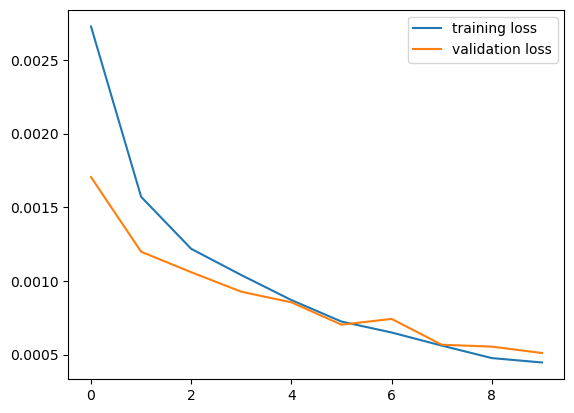

In [15]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [16]:
print("Evaluating model...")
model.evaluate(val_generator, steps=len(validation_samples) // 32)

Evaluating model...
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.2615e-04


0.0005174094112589955

In [17]:
model.save('behavioural_cloning_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


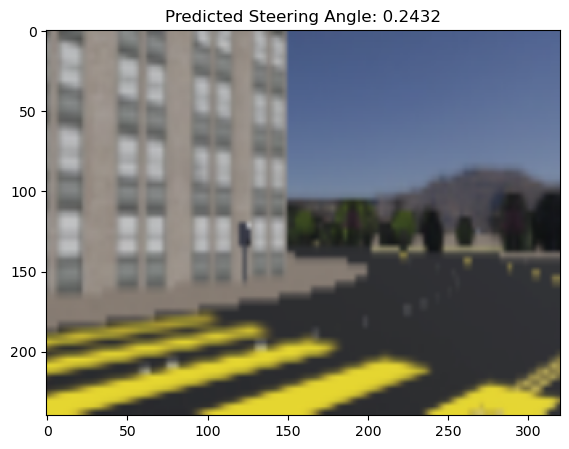

In [19]:
# Función para cargar y preprocesar la imagen
def load_and_preprocess_image(image_path):
    # Cargar la imagen
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    
    # Redimensionar la imagen para que coincida con la entrada del modelo
    img_resized = cv2.resize(img, (200, 66))
    
    # Normalizar la imagen
    img_normalized = img_resized / 255.0 - 0.5
    
    # Añadir una dimensión de batch
    img_batch = np.expand_dims(img_normalized, axis=0)
    return img_batch

# Ruta a tu imagen
image_path = 'captured_images/2024-06-21 22-49-36-254.png'

# Cargar y preprocesar la imagen
prepared_image = load_and_preprocess_image(image_path)

# Obtener la predicción del modelo
predicted_steering_angle = model.predict(prepared_image)[0][0]

# Mostrar la imagen y la predicción
plt.figure(figsize=(10, 5))
# Primero convertir la imagen normalizada de vuelta a uint8
image_to_show = (prepared_image[0] + 0.5) * 255.0
image_to_show = np.clip(image_to_show, 0, 255).astype('uint8')
image_to_show = cv2.resize(image_to_show, (320, 240))  # Opcional: Cambiar el tamaño para la visualización
plt.imshow(image_to_show)  # Mostrar usando matplotlib
plt.title(f"Predicted Steering Angle: {predicted_steering_angle:.4f}")
plt.show()